In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
from util_visualization import plot_feature_importances, plot_roc_curve
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, mean_absolute_percentage_error, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import roc_auc_score, roc_curve, auc
from pylab import rcParams
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
import pickle
import importlib
import sys
import joblib
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

## Import Data

In [30]:
# Load the labeled index data from csv
labeled_index = pd.read_csv("../data/labeled_data/lagged_labeled_data.csv")

In [31]:
labeled_index

,index,crash_label,date,Quarter,000001.SS,^BSESN,^BVSP,^FCHI,^FTLC,^GDAXI,...,npl_lag1,npl_lag2,Recession_Indicators_lag1,Recession_Indicators_lag2,inflation_lag1,inflation_lag2,Unemployment_lag1,Unemployment_lag2,GDP_lag1,GDP_lag2
0,000001.SS,1,1998-09-30,Q3 1998,1.0,0.0,0.0,0.0,0.0,0.0,...,0.203637,0.203637,1.121317,1.121317,0.036556,-0.029370,0.066845,0.066845,0.246733,0.246733
1,000001.SS,0,1998-12-31,Q4 1998,1.0,0.0,0.0,0.0,0.0,0.0,...,0.203637,0.203637,1.121317,1.121317,0.037809,0.036556,0.066845,0.066845,0.246733,0.246733
2,000001.SS,0,1999-03-31,Q1 1999,1.0,0.0,0.0,0.0,0.0,0.0,...,0.203637,0.203637,1.121317,1.121317,0.033007,0.037809,0.066845,0.066845,0.246733,0.246733
3,000001.SS,0,1999-06-30,Q2 1999,1.0,0.0,0.0,0.0,0.0,0.0,...,0.201522,0.203637,1.121317,1.121317,0.019243,0.033007,0.311972,0.066845,0.173266,0.246733
4,000001.SS,0,1999-09-30,Q3 1999,1.0,0.0,0.0,0.0,0.0,0.0,...,0.201522,0.201522,1.121317,1.121317,0.062352,0.019243,0.311972,0.311972,0.173266,0.173266
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
855,^SSMI,0,2018-12-31,Q4 2018,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.349336,-0.349336,1.121317,0.071015,0.029637,0.035223,-0.082835,-0.082835,-0.032256,-0.032256
856,^SSMI,0,2019-03-31,Q1 2019,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.349336,-0.349336,1.121317,1.121317,0.025428,0.029637,-0.082835,-0.082835,-0.032256,-0.032256
857,^SSMI,0,2019-06-30,Q2 2019,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.351040,-0.349336,1.121317,1.121317,0.008938,0.025428,-0.487134,-0.082835,-0.569956,-0.032256
858,^SSMI,0,2019-09-30,Q3 2019,0.0,0.0,0.0,0.0,0.0,0.0,...,2.680854,-0.351040,1.121317,1.121317,0.052412,0.008938,-0.487134,-0.487134,-0.569956,-0.569956


In [32]:
labeled_index.set_index(labeled_index['date'], inplace=True)
quarters = np.sort(labeled_index.index.unique())

In [33]:
features_columns = ['volatility_lag1', 'volatility_lag2','price_change_lag1', 'price_change_lag2', 'volume_change_lag1', 'volume_change_lag2','000001.SS','^BSESN','^BVSP','^FCHI','^FTLC','^GDAXI','^GSPC','^HSI','^N225','^SSMI']

## Build the model

In [34]:
# Call TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)
evaluation = []
shap_values_list = []
best_params_list = []

for train_index, val_test_index in tscv.split(quarters):
    val_index = val_test_index[:int(len(val_test_index) * 0.5)]
    test_index = val_test_index[int(len(val_test_index) * 0.5):]
    train_quarters, val_quarters, test_quarters = quarters[train_index], quarters[val_index], quarters[test_index]
    train = labeled_index.loc[train_quarters]
    val = labeled_index.loc[val_quarters]
    test = labeled_index.loc[test_quarters]
    X_train = train[features_columns]
    y_train = train['crash_label']
    X_val = val[features_columns]
    y_val = val['crash_label']
    X_test = test[features_columns]
    y_test = test['crash_label']
    
    # Oversample the minority class (1) using SMOTE
    oversampler = SMOTE()
    X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train, y_train)

    # Hyperparameter Tuning with val
    if not all(label == 0 for label in y_val):
        param_grid = {"penalty": ['none', 'l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'solver': ['lbfgs', 'liblinear', 'sag', 'saga'], 'class_weight': [None, 'balanced']}
        grid_search = GridSearchCV(LogisticRegression(), param_grid=param_grid, cv=tscv, scoring='f1', verbose=2)
        grid_search.fit(X_val, y_val)
        best_params = grid_search.best_params_
        best_score = grid_search.best_score_
        best_params_list.append(best_params)
        print(f"Best Score: {best_score}")
        print("Grid search completed successfully.")
    else:
        best_params = best_params_list[-1]
    
    # Train the model
    model = LogisticRegression(penalty=best_params['penalty'], C=best_params['C'], solver=best_params['solver'], class_weight=best_params['class_weight'])
    model.fit(X_train_resampled, y_train_resampled)
    
    # Evaluate the model
    y_pred = model.predict(X_test)
    
    # Predict probabilities on the test data
    y_prob = model.predict_proba(X_test)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

    conf_matrix = confusion_matrix(y_test, y_pred, labels= [0,1])
    
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc_roc = roc_auc_score(y_test, y_prob)
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    
    explainer = shap.Explainer(model.predict, X_test)
    shap_values = explainer(X_test)
    shap_values_list.append(shap_values)
    
    evaluation_result = {
        'Train_Start': pd.to_datetime(train_quarters).min(),
        'Train_End': pd.to_datetime(train_quarters).max(),
        'Val_Start': pd.to_datetime(val_quarters).min(),
        'Val_End': pd.to_datetime(val_quarters).max(),
        'Test_Start': pd.to_datetime(test_quarters).min(),
        'Test_End': pd.to_datetime(test_quarters).max(),
        'Confusion_Matrix': conf_matrix, #[[TN, FP],[FN,TP]]
        'Precision': precision, 
        'Recall': recall, 
        'F1': f1, 
        'Accuracy': accuracy, 
        'RMSE': rmse,
        'MAPE': mape,
        'AUC-ROC': auc_roc,
        'False Positive Rate': fpr,
        'True Positive Rate': tpr
    }
    
    # Feature Importance
    feature_names = list(X_train.columns)
    feature_importance = model.coef_[0]
    for name, importance in zip(feature_names, feature_importance):
        evaluation_result[f"{name}_importance"] = importance

    # Append result to evaluation
    evaluation.append(evaluation_result)

Fitting 5 folds for each of 168 candidates, totalling 840 fits
[CV] END C=0.001, class_weight=None, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END C=0.001, class_weight=None, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END C=0.001, class_weight=None, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END C=0.001, class_weight=None, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END C=0.001, class_weight=None, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END C=0.001, class_weight=None, penalty=none, solver=liblinear; total time=   0.0s
[CV] END C=0.001, class_weight=None, penalty=none, solver=liblinear; total time=   0.0s
[CV] END C=0.001, class_weight=None, penalty=none, solver=liblinear; total time=   0.0s
[CV] END C=0.001, class_weight=None, penalty=none, solver=liblinear; total time=   0.0s
[CV] END C=0.001, class_weight=None, penalty=none, solver=liblinear; total time=   0.0s
[CV] END C=0.001, class_weight=None, penalty=none, solver=sag; total time=   

[CV] END C=0.001, class_weight=balanced, penalty=l1, solver=saga; total time=   0.0s
[CV] END C=0.001, class_weight=balanced, penalty=l1, solver=saga; total time=   0.0s
[CV] END C=0.001, class_weight=balanced, penalty=l1, solver=saga; total time=   0.0s
[CV] END C=0.001, class_weight=balanced, penalty=l1, solver=saga; total time=   0.0s
[CV] END C=0.001, class_weight=balanced, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END C=0.001, class_weight=balanced, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END C=0.001, class_weight=balanced, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END C=0.001, class_weight=balanced, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END C=0.001, class_weight=balanced, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END C=0.001, class_weight=balanced, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=0.001, class_weight=balanced, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=0.001, class_weight=balanced, penalty=l

[CV] END ..C=0.1, class_weight=None, penalty=l1, solver=saga; total time=   0.0s
[CV] END ..C=0.1, class_weight=None, penalty=l1, solver=saga; total time=   0.0s
[CV] END ..C=0.1, class_weight=None, penalty=l1, solver=saga; total time=   0.0s
[CV] END ..C=0.1, class_weight=None, penalty=l1, solver=saga; total time=   0.0s
[CV] END .C=0.1, class_weight=None, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END .C=0.1, class_weight=None, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END .C=0.1, class_weight=None, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END .C=0.1, class_weight=None, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END .C=0.1, class_weight=None, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END C=0.1, class_weight=None, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=0.1, class_weight=None, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=0.1, class_weight=None, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=0.1, cla

[CV] END C=1, class_weight=balanced, penalty=l1, solver=saga; total time=   0.0s
[CV] END C=1, class_weight=balanced, penalty=l1, solver=saga; total time=   0.0s
[CV] END C=1, class_weight=balanced, penalty=l1, solver=saga; total time=   0.0s
[CV] END C=1, class_weight=balanced, penalty=l1, solver=saga; total time=   0.0s
[CV] END C=1, class_weight=balanced, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END C=1, class_weight=balanced, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END C=1, class_weight=balanced, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END C=1, class_weight=balanced, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END C=1, class_weight=balanced, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END C=1, class_weight=balanced, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=1, class_weight=balanced, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=1, class_weight=balanced, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END

[CV] END C=100, class_weight=None, penalty=none, solver=saga; total time=   0.0s
[CV] END C=100, class_weight=None, penalty=none, solver=saga; total time=   0.0s
[CV] END C=100, class_weight=None, penalty=none, solver=saga; total time=   0.0s
[CV] END C=100, class_weight=None, penalty=none, solver=saga; total time=   0.0s
[CV] END C=100, class_weight=None, penalty=none, solver=saga; total time=   0.0s
[CV] END .C=100, class_weight=None, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END .C=100, class_weight=None, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END .C=100, class_weight=None, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END .C=100, class_weight=None, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END .C=100, class_weight=None, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END C=100, class_weight=None, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=100, class_weight=None, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=100, class_

[CV] END C=1000, class_weight=None, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END C=1000, class_weight=None, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=1000, class_weight=None, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=1000, class_weight=None, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=1000, class_weight=None, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=1000, class_weight=None, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ..C=1000, class_weight=None, penalty=l2, solver=sag; total time=   0.0s
[CV] END ..C=1000, class_weight=None, penalty=l2, solver=sag; total time=   0.0s
[CV] END ..C=1000, class_weight=None, penalty=l2, solver=sag; total time=   0.0s
[CV] END ..C=1000, class_weight=None, penalty=l2, solver=sag; total time=   0.0s
[CV] END ..C=1000, class_weight=None, penalty=l2, solver=sag; total time=   0.0s
[CV] END .C=1000, class_weight=None, penalty=l2, solver=saga; total time=   0.0s
[CV] END

[CV] END C=0.001, class_weight=None, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=0.001, class_weight=None, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=0.001, class_weight=None, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END .C=0.001, class_weight=None, penalty=l2, solver=sag; total time=   0.0s
[CV] END .C=0.001, class_weight=None, penalty=l2, solver=sag; total time=   0.0s
[CV] END .C=0.001, class_weight=None, penalty=l2, solver=sag; total time=   0.0s
[CV] END .C=0.001, class_weight=None, penalty=l2, solver=sag; total time=   0.0s
[CV] END .C=0.001, class_weight=None, penalty=l2, solver=sag; total time=   0.0s
[CV] END C=0.001, class_weight=None, penalty=l2, solver=saga; total time=   0.0s
[CV] END C=0.001, class_weight=None, penalty=l2, solver=saga; total time=   0.0s
[CV] END C=0.001, class_weight=None, penalty=l2, solver=saga; total time=   0.0s
[CV] END C=0.001, class_weight=None, penalty=l2, solver=saga; total time=   0.0s
[CV] END C=0.

[CV] END C=0.01, class_weight=balanced, penalty=l1, solver=saga; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, penalty=l1, solver=saga; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, penalty=l2,

[CV] END ....C=1, class_weight=None, penalty=l1, solver=saga; total time=   0.0s
[CV] END ....C=1, class_weight=None, penalty=l1, solver=saga; total time=   0.0s
[CV] END ....C=1, class_weight=None, penalty=l1, solver=saga; total time=   0.0s
[CV] END ....C=1, class_weight=None, penalty=l1, solver=saga; total time=   0.0s
[CV] END ...C=1, class_weight=None, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END ...C=1, class_weight=None, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END ...C=1, class_weight=None, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END ...C=1, class_weight=None, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END ...C=1, class_weight=None, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END C=1, class_weight=None, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=1, class_weight=None, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=1, class_weight=None, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=1, class_weigh

[CV] END C=10, class_weight=balanced, penalty=none, solver=saga; total time=   0.0s
[CV] END C=10, class_weight=balanced, penalty=none, solver=saga; total time=   0.0s
[CV] END C=10, class_weight=balanced, penalty=none, solver=saga; total time=   0.0s
[CV] END C=10, class_weight=balanced, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END C=10, class_weight=balanced, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END C=10, class_weight=balanced, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END C=10, class_weight=balanced, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END C=10, class_weight=balanced, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END C=10, class_weight=balanced, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=10, class_weight=balanced, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=10, class_weight=balanced, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=10, class_weight=balanced, penalty=l1, solver=liblinear; tota

[CV] END C=1000, class_weight=None, penalty=none, solver=liblinear; total time=   0.0s
[CV] END C=1000, class_weight=None, penalty=none, solver=liblinear; total time=   0.0s
[CV] END C=1000, class_weight=None, penalty=none, solver=liblinear; total time=   0.0s
[CV] END C=1000, class_weight=None, penalty=none, solver=sag; total time=   0.0s
[CV] END C=1000, class_weight=None, penalty=none, solver=sag; total time=   0.0s
[CV] END C=1000, class_weight=None, penalty=none, solver=sag; total time=   0.0s
[CV] END C=1000, class_weight=None, penalty=none, solver=sag; total time=   0.0s
[CV] END C=1000, class_weight=None, penalty=none, solver=sag; total time=   0.0s
[CV] END C=1000, class_weight=None, penalty=none, solver=saga; total time=   0.0s
[CV] END C=1000, class_weight=None, penalty=none, solver=saga; total time=   0.0s
[CV] END C=1000, class_weight=None, penalty=none, solver=saga; total time=   0.0s
[CV] END C=1000, class_weight=None, penalty=none, solver=saga; total time=   0.0s
[CV] E

Fitting 5 folds for each of 168 candidates, totalling 840 fits
[CV] END C=0.001, class_weight=None, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END C=0.001, class_weight=None, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END C=0.001, class_weight=None, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END C=0.001, class_weight=None, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END C=0.001, class_weight=None, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END C=0.001, class_weight=None, penalty=none, solver=liblinear; total time=   0.0s
[CV] END C=0.001, class_weight=None, penalty=none, solver=liblinear; total time=   0.0s
[CV] END C=0.001, class_weight=None, penalty=none, solver=liblinear; total time=   0.0s
[CV] END C=0.001, class_weight=None, penalty=none, solver=liblinear; total time=   0.0s
[CV] END C=0.001, class_weight=None, penalty=none, solver=liblinear; total time=   0.0s
[CV] END C=0.001, class_weight=None, penalty=none, solver=sag; total time=   

[CV] END C=0.01, class_weight=balanced, penalty=none, solver=saga; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, penalty=none, solver=saga; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, penalty=none, solver=saga; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, penalty=l1

[CV] END C=0.1, class_weight=balanced, penalty=none, solver=sag; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, penalty=none, solver=saga; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, penalty=none, solver=saga; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, penalty=none, solver=saga; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, penalty=none, solver=saga; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, penalty=none, solver=saga; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, penalty=l1, solver=liblinear; to

[CV] END C=1, class_weight=balanced, penalty=none, solver=liblinear; total time=   0.0s
[CV] END C=1, class_weight=balanced, penalty=none, solver=liblinear; total time=   0.0s
[CV] END C=1, class_weight=balanced, penalty=none, solver=liblinear; total time=   0.0s
[CV] END C=1, class_weight=balanced, penalty=none, solver=liblinear; total time=   0.0s
[CV] END C=1, class_weight=balanced, penalty=none, solver=liblinear; total time=   0.0s
[CV] END C=1, class_weight=balanced, penalty=none, solver=sag; total time=   0.0s
[CV] END C=1, class_weight=balanced, penalty=none, solver=sag; total time=   0.0s
[CV] END C=1, class_weight=balanced, penalty=none, solver=sag; total time=   0.0s
[CV] END C=1, class_weight=balanced, penalty=none, solver=sag; total time=   0.0s
[CV] END C=1, class_weight=balanced, penalty=none, solver=sag; total time=   0.0s
[CV] END C=1, class_weight=balanced, penalty=none, solver=saga; total time=   0.0s
[CV] END C=1, class_weight=balanced, penalty=none, solver=saga; tot

[CV] END ...C=10, class_weight=None, penalty=l2, solver=saga; total time=   0.0s
[CV] END ...C=10, class_weight=None, penalty=l2, solver=saga; total time=   0.0s
[CV] END C=10, class_weight=balanced, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END C=10, class_weight=balanced, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END C=10, class_weight=balanced, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END C=10, class_weight=balanced, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END C=10, class_weight=balanced, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END C=10, class_weight=balanced, penalty=none, solver=liblinear; total time=   0.0s
[CV] END C=10, class_weight=balanced, penalty=none, solver=liblinear; total time=   0.0s
[CV] END C=10, class_weight=balanced, penalty=none, solver=liblinear; total time=   0.0s
[CV] END C=10, class_weight=balanced, penalty=none, solver=liblinear; total time=   0.0s
[CV] END C=10, class_weight=balanced, penalty=none, solve

[CV] END C=100, class_weight=None, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=100, class_weight=None, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=100, class_weight=None, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=100, class_weight=None, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=100, class_weight=None, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ...C=100, class_weight=None, penalty=l2, solver=sag; total time=   0.0s
[CV] END ...C=100, class_weight=None, penalty=l2, solver=sag; total time=   0.0s
[CV] END ...C=100, class_weight=None, penalty=l2, solver=sag; total time=   0.0s
[CV] END ...C=100, class_weight=None, penalty=l2, solver=sag; total time=   0.0s
[CV] END ...C=100, class_weight=None, penalty=l2, solver=sag; total time=   0.0s
[CV] END ..C=100, class_weight=None, penalty=l2, solver=saga; total time=   0.0s
[CV] END ..C=100, class_weight=None, penalty=l2, solver=saga; total time=   0.0s
[CV] END ..C=

[CV] END C=1000, class_weight=None, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=1000, class_weight=None, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ..C=1000, class_weight=None, penalty=l1, solver=sag; total time=   0.0s
[CV] END ..C=1000, class_weight=None, penalty=l1, solver=sag; total time=   0.0s
[CV] END ..C=1000, class_weight=None, penalty=l1, solver=sag; total time=   0.0s
[CV] END ..C=1000, class_weight=None, penalty=l1, solver=sag; total time=   0.0s
[CV] END ..C=1000, class_weight=None, penalty=l1, solver=sag; total time=   0.0s
[CV] END .C=1000, class_weight=None, penalty=l1, solver=saga; total time=   0.0s
[CV] END .C=1000, class_weight=None, penalty=l1, solver=saga; total time=   0.0s
[CV] END .C=1000, class_weight=None, penalty=l1, solver=saga; total time=   0.0s
[CV] END .C=1000, class_weight=None, penalty=l1, solver=saga; total time=   0.0s
[CV] END .C=1000, class_weight=None, penalty=l1, solver=saga; total time=   0.0s
[CV] END C=1000, cla

In [35]:
evaluation_df = pd.DataFrame(evaluation)
evaluation_df.to_csv('./evaluation_result/' + f"evaluation_benchmark.csv", index=False)
evaluation_df
#[[TN, FP],[FN,TP]]

,Train_Start,Train_End,Val_Start,Val_End,Test_Start,Test_End,Confusion_Matrix,Precision,Recall,F1,...,000001.SS_importance,^BSESN_importance,^BVSP_importance,^FCHI_importance,^FTLC_importance,^GDAXI_importance,^GSPC_importance,^HSI_importance,^N225_importance,^SSMI_importance
0,1998-09-30,2002-06-30,2002-09-30,2004-03-31,2004-06-30,2005-12-31,"[[47, 21], [1, 1]]",0.045455,0.500000,0.083333,...,-0.166567,0.459152,0.282836,-0.124717,-0.376766,0.117328,0.124898,0.097112,-0.406791,-0.006534
1,1998-09-30,2005-12-31,2006-03-31,2007-09-30,2007-12-31,2009-06-30,"[[12, 30], [7, 21]]",0.411765,0.750000,0.531646,...,-0.310993,0.987072,-0.684759,0.093662,-0.188809,0.346119,0.348652,-0.493824,-0.595894,0.380405
2,1998-09-30,2009-06-30,2009-09-30,2011-03-31,2011-06-30,2012-12-31,"[[43, 21], [4, 2]]",0.086957,0.333333,0.137931,...,0.017361,0.589841,-0.540120,0.208010,0.021929,0.293977,-0.137110,-0.053682,-0.770429,-0.053330
3,1998-09-30,2012-12-31,2013-03-31,2014-09-30,2014-12-31,2016-06-30,"[[36, 23], [7, 4]]",0.148148,0.363636,0.210526,...,-0.420677,0.578520,-0.399989,0.388755,-0.189370,0.419513,-0.304973,0.050296,-0.531997,-0.052575
4,1998-09-30,2016-06-30,2016-09-30,2018-03-31,2018-06-30,2019-12-31,"[[39, 30], [1, 0]]",0.000000,0.000000,0.000000,...,-0.318121,0.145288,-0.917120,0.086293,-0.024402,0.182565,-0.115027,0.295944,0.041583,0.198318


## Shap Values
- color: how higher and lower values of the feature will affect the result
- X-axis: impact on output

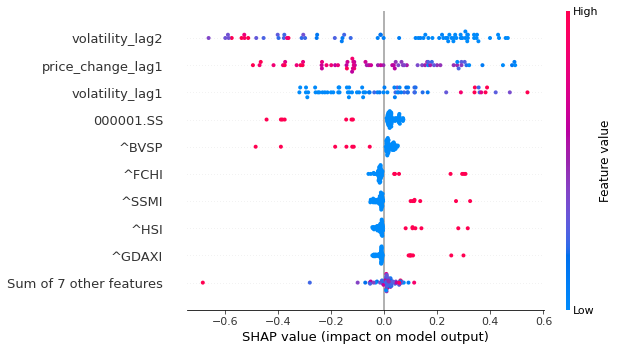

In [36]:
shap.plots.beeswarm(shap_values_list[4])

## Feature Importance

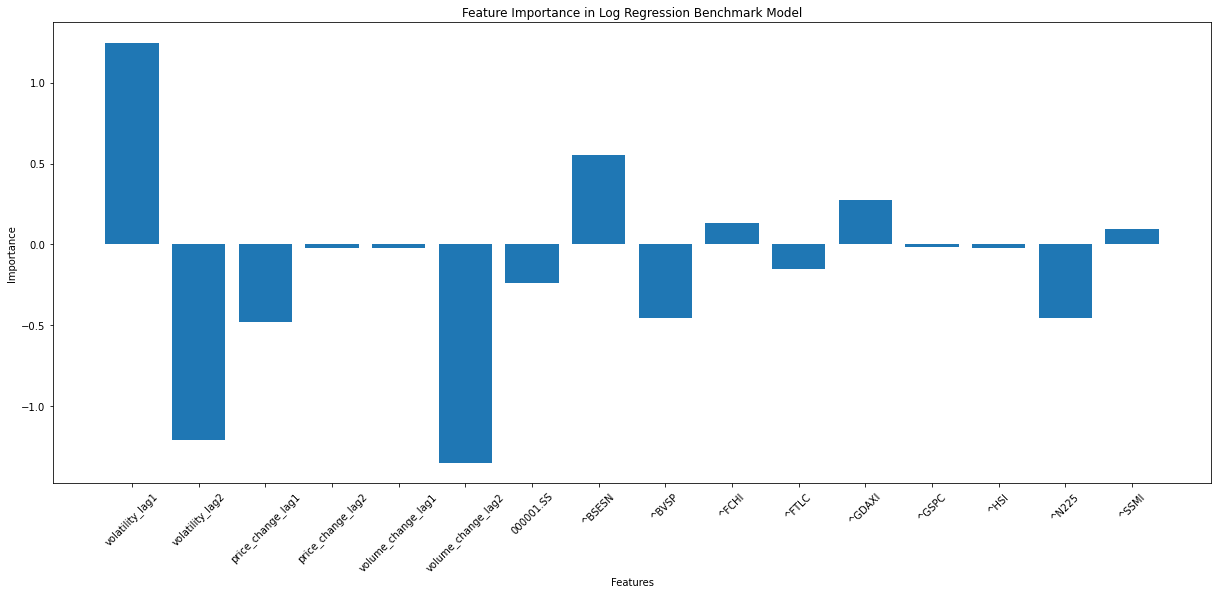

In [37]:
model_name = "Log Regression Benchmark"
plot_feature_importances(evaluation_df, model_name)

## AUC-ROC

In [38]:
print("Mean AUC Score: ", np.mean(evaluation_df['AUC-ROC']))

Mean AUC Score:  0.43621030754701556


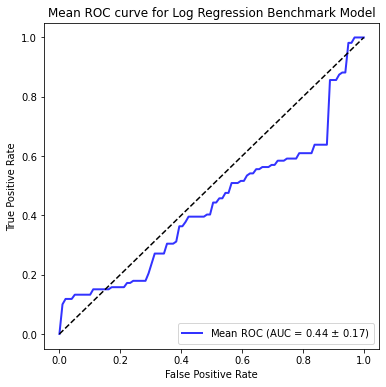

In [39]:
plot_roc_curve(evaluation_df, model_name)